# Fine-tuning a VLM for Structured Food Tag Extraction

Goal:
* Input: Food or not food image
* Output: Structured data for whether or not the image is food or not + food/ drink tags

## Resources
* Docs example of fine-tuning a VLM: https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora?hl=tr
* Another doc example of inference with a VLM: https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3n]Multimodal_understanding_with_HF.ipynb
* LoRa without regret https://huggingface.co/docs/trl/main/en/index
    * Thinking Machines blog: https://thinkingmachines.ai/blog/lora/
* Example of LoRA in the wild: https://developer.apple.com/apple-intelligence/foundation-models-adapter/

* PEFT (Parameter Efficient Fine-tuning) GitHub - https://github.com/huggingface/peft

* SmolVLM Docling paper - https://arxiv.org/pdf/2503.11576
  * Notes:
    * LLM alignment: To align the LLM part we freeze the vision encoder and train only the remaining network to adaph it to the new output format which it hasn't seen before.
    * Unfreeze vision encoder: After LLM alignment, unfreeze vision encoder and train the model on pretraining datasets (section 4.1) along with all task-specific conversion datasets inculuding tables, code, equations and charts
    * Workflow:
      * Stage 1 (frozen vision encoder): Freeze the vision encoder and teach the LLM part to output our desired structure (e.g. JSON for food/drink)
        * Note: Create a Trainer instance (STrainer) with one optimizer to get the state of the model and optimize it with a frozen vision backbone.
      * Stage 2 (unfrozen whole model): Unfreeze the vision encoder and teach the whole model to converge to your desired structure.


## Definitions

* PEFT = Parameter Efficient Fine-Tuning (only train a subset of the model parameters + hopefully still get good results)

* LORA = Low Rank Adaptation (LoRA = a form of PET)
    * You basically fine-tune an adapter model for your original model and optionally apply the adapter to the original model
    * Benefits of LoRA = you can train multiple adapters only and run different times depending on the required use case of your model

* QloRA = Quantized LoRA (fine-tune an adapter)
    * Train with quantized weights (even smaller than LoRA) for even more parameter efficient fine-tuning

In [1]:
!pip install trl
!pip install num2words
!pip install spaces

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.9/530.9 kB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 14.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=c5080e0471251736ea4ed460d558219456c51459dafa89b92f718af80504b1cf
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.2/105.2 kB 10.9 MB/s eta 0:00:00


In [2]:
import transformers
import torch
import trl

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [4]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("berkeruveyik/vlm-food-4k-not-food-dataset")
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/263M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3698 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'category', 'output_json', 'output_yaml', 'image_name', 'image_id', 'food270_class_name', 'image_source', 'label'],
        num_rows: 3698
    })
})

In [5]:
example_sample =dataset['train'][330]
example_sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'category': 'beignets',
 'output_json': {'is_food': 1,
  'image_title': 'beignets',
  'food_items': ['sugar',
   'flour',
   'butter',
   'eggs',
   'milk',
   'cinnamon',
   'nutmeg',
   'vanilla extract'],
  'drink_items': []},
 'output_yaml': {'is_food': 1,
  'image_title': 'beignets',
  'food_items': ['sugar',
   'flour',
   'butter',
   'eggs',
   'milk',
   'cinnamon',
   'nutmeg',
   'vanilla extract'],
  'drink_items': []},
 'image_name': '26e72132134c47b0a9a3af5da2642ceb.jpg',
 'image_id': '26e72132134c47b0a9a3af5da2642ceb',
 'food270_class_name': 'beignets',
 'image_source': 'food270',
 'label': 1}

[INFO] Example output: {'is_food': 1, 'image_title': 'beignets', 'food_items': ['sugar', 'flour', 'butter', 'eggs', 'milk', 'cinnamon', 'nutmeg', 'vanilla extract'], 'drink_items': []}


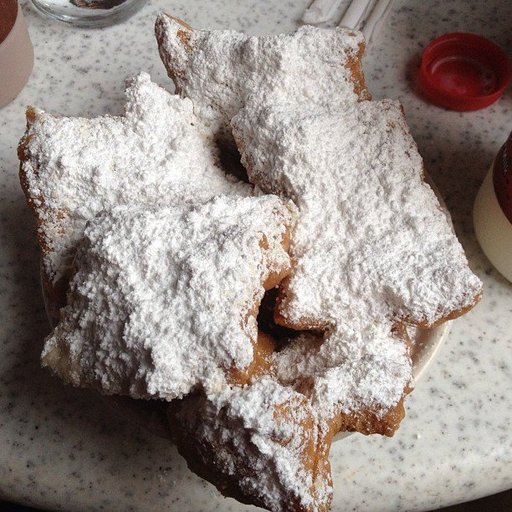

In [6]:
example_input = example_sample['image']
example_output = example_sample['output_json']

print(f'[INFO] Example output: {example_output}')
example_input

## format data for use with a VLM
* Input: image
* Output: structured json data with food tags

In [7]:
# system mesage
SYSTEM_MESSAGE = """ You are an expert food and drink image extractor.
You provide structured data to visual inputs classifying them as edible food/drink or not.
as well as titling the image with a simple simple food/drink related caption.
Finally you extract any and all visible food/drink items to lists.
"""

# user prompt with image input as well ass desired output
USER_PROMPT = """ Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.

Only return valid JSON in the following form:

```json

{
    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
    'food_items' : [], # list[str] - list of visible edible food item nouns
    'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
"""

# create helper function to map our input/output sample to conversational format
def format_data(sample):
    return{
        'messages':[
            # Message 0 - [SYSTEM] System prompt (setting the scene)
            {
                'role': 'system',
                'content': [{'type':'text', 'text': SYSTEM_MESSAGE}]
            },
            # Message 1 - [USER] User input (image + prompt pair)
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'image',
                        'image': sample['image']
                    },
                    {
                        'type': 'text',
                        'text': USER_PROMPT
                    },
                ]
            },
            # Message 2 - [MODEL] Ideal model output (structured json data)
            {
                'role': 'assistant',
                'content': [
                    {
                        'type': 'text',
                        'text': sample['output_json']
                    }
                ]
            },
        ]
    }

formatted_sample = format_data(example_sample)
formatted_sample

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the ima

In [8]:
# Format each item in the original dataset keeping the PIL image type
# Note: If we use •map(), image may get converted to bytes
dataset_processed = [format_data(sample) for sample in dataset["train"]]
dataset_processed[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the ima

In [9]:
# this took too long skipping for now
'''
dataset = dataset.map(format_data,
                      batched=False)

dataset["train"][0]

'''

'\ndataset = dataset.map(format_data,\n                      batched=False)\n\ndataset["train"][0]\n\n'

## Running a sample through a base model

Let's see how a non-fine-tuned model performs on our task.

To begin with we'll try out SmolVLM2-256M - https://huggingface.co/HuggingFaceTB/SmolVLM-256M-Instruct

In [10]:
example_base_model_input = dataset_processed[1576]['messages'][:2]  # only input messages (no output)
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>},
   {'type': 'text',
    'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if n

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline
from google.colab import userdata
import torch # Ensure torch is imported for torch.bfloat16

MODEL_ID = 'HuggingFaceTB/SmolVLM2-500M-Video-Instruct'

# Retrieve the Hugging Face token from Colab secrets
hf_token = userdata.get('HF_TOKEN')

pipe = pipeline(
    'image-text-to-text',
    model=MODEL_ID,
    device='cuda',
    dtype=torch.bfloat16, # Use torch_dtype explicitly for better consistency
    token=hf_token  # Pass the token explicitly
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/471 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

In [ ]:
# Test the base model on an example input image
base_model_output = pipe(example_base_model_input,
                         max_new_tokens=256)

print(f"[INFO] Base model output:\n{base_model_output[0]['generated_text'][-1]['content']}")


Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Base model output:
 The given image is a food or drink item.


In [ ]:
print(f'[INFO] Ideal model output:\n')
dataset_processed[1576]['messages'][2]['content'][0]['text']

[INFO] Ideal model output:



{'is_food': 1,
 'image_title': 'lokma_dessert',
 'food_items': ['syrup', 'powdered sugar', 'red fruit topping', 'cake base'],
 'drink_items': []}

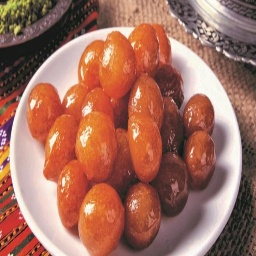

In [ ]:
example_base_model_input[1]['content'][0]['image']

## Load the model without using pipline

`transformers. pipelin` allows simple loading and inference of the model.

But for more customization we'll want to load the model directly.|

In [13]:
MODEL_ID = 'HuggingFaceTB/SmolVLM2-500M-Video-Instruct'

In [14]:
# Load model in non-pipline way for more customization on the load
# Improve base model to be mode aligned with our ideal outputs

import torch
from transformers import  AutoModelForImageTextToText,AutoProcessor


print(f'[INFO] using model {MODEL_ID}')

# define model init args
model_kwargs = dict(
    attn_implementation='eager',
    dtype=torch.bfloat16,
    device_map='auto'
)

# BitsAndBytesConfig int-4 config
# TK - Load the model in 4bit for smaller footprint? Not 100% sure on this...
# Note: If you are loading a quantized model, make sure the inputs are quantized as well,otherwise you will get errors.

#model_kwargs['quantization_config'] = BitsAndBytesConfig(
#    load_in_4bit=True,
#    bnb_4bit_use_double_quant=True,
#    bnb_4bit_quant_type="nf4",
#    bnb_4bit_compute_dtype=model_kwargs["dtype"],
#    bnb_4bit_quant_storage=model_kwargs["dtype"]
#    )

model = AutoModelForImageTextToText.from_pretrained(MODEL_ID,
                                                    **model_kwargs)
processor = AutoProcessor.from_pretrained(MODEL_ID)

[INFO] using model HuggingFaceTB/SmolVLM2-500M-Video-Instruct


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.03G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

In [15]:
model

SmolVLMForConditionalGeneration(
  (model): SmolVLMModel(
    (vision_model): SmolVLMVisionTransformer(
      (embeddings): SmolVLMVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): SmolVLMEncoder(
        (layers): ModuleList(
          (0-11): 12 x SmolVLMEncoderLayer(
            (self_attn): SmolVLMVisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): SmolVLMVisionMLP(
              (activation_fn): GELUTanh()
              (fc1): Linear(in_features=768, out_feature

In [ ]:
#example_base_model_input_clone = example_base_model_input
#example_base_model_input_clone

In [ ]:
#example_base_model_input_clone[1]['content'][0]['image'] = 'https://101limerick.com/wp-content/uploads/2025/08/Screenshot-2025-08-26-at-16.23.50.png'

In [ ]:
#example_base_model_input_clone[1]

In [ ]:
#example_base_model_input[1]

In [16]:
# Run the model on our example sample
example_chat_template_input = processor.apply_chat_template(
    [example_base_model_input[1]],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors='pt'
).to(model.device, dtype=torch.bfloat16) # Move input to model's device and dtype, ensuring type consistency

# example_chat_template_input

input_len = example_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

with torch.inference_mode():
  generation_output_full = model.generate(**example_chat_template_input,
                                    max_new_tokens=256,
                                    do_sample=False)
  generation_output_short = generation_output_full[0][input_len:]

decoded_outputs = processor.decode(generation_output_short,
                                   skip_special_tokens=True)

print(decoded_outputs)

[INFO] Input length: 1315
 [
]


## Train with smallVLM

### Setup SFTConfig

In [17]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="smolvlm2-500m-FoodExtract-Vision-v3",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=25,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=1,
    max_grad_norm=1.0,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to="none",
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    load_best_model_at_end=True,
)

training_args.remove_unused_columns = False  # important for collator


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Next we'll create a data collator to encode text and image pairs into batches.

We'll also create a helper function called 'process_vision_info to stack vision tensors.

In [18]:
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs


In [19]:
processor.tokenizer.pad_token_id

2

In [20]:
processor.tokenizer. convert_ids_to_tokens (262144)

In [21]:
# collate_fn fonksiyonunu hatayı düzelterek burada yeniden tanımlıyoruz
def collate_fn(examples):
    texts = []
    images = []

    for example in examples:
        image_inputs = process_vision_info(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )

        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch_input = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True
    )

    labels = batch_input["input_ids"].clone()

    # HATA DÜZELTME: convert_tokens_to_ids kullanıyoruz
    image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")

    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100

    batch_input["labels"] = labels
    return batch_input

In [22]:
import random
random.seed(42)

dataset_shuffled = random.sample(dataset_processed, k=len(dataset_processed))

train_split = round(0.8 * len(dataset_processed))

train_dataset = dataset_shuffled[:train_split]
val_dataset = dataset_shuffled[train_split:]

print(f" [INFO] Number of total samples: {len(dataset_processed)}")
print(f" [INFO] Number of train samples: {len(train_dataset)}")
print (f" [INFO] Number of eval samples: {len(val_dataset)}")

 [INFO] Number of total samples: 3698
 [INFO] Number of train samples: 2958
 [INFO] Number of eval samples: 740


In [23]:
random.choice(train_dataset)

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=308x512>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if

In [24]:
train_dataset[0], val_dataset[0]

({'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
   {'role': 'user',
    'content': [{'type': 'image',
      'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
     {'type': 'text',
      'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in

### freeze the vision backbone

In [25]:
# freeze the vision bavkbone and only train the LLM parts
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

# Before freezing
total, trainable, frozen = count_parameters(model)
print("Before freezing:")
print(f"  Total: {total:,}")
print(f"  Trainable: {trainable:,}")
print(f"  Frozen: {frozen:,}")

# Freeze vision model
for param in model.model.vision_model.parameters():
    param.requires_grad = False

# After freezing
total, trainable, frozen = count_parameters(model)
print("\nAfter freezing vision_model:")
print(f"  Total: {total:,}")
print(f"  Trainable: {trainable:,}")
print(f"  Frozen: {frozen:,}")


Before freezing:
  Total: 507,482,304
  Trainable: 507,482,304
  Frozen: 0

After freezing vision_model:
  Total: 507,482,304
  Trainable: 421,049,280
  Frozen: 86,433,024


In [26]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=processor,
    data_collator=collate_fn
)

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 49279, 'bos_token_id': 1, 'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.034282,0.028946
2,0.022115,0.023815


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=186, training_loss=0.07569569613664381, metrics={'train_runtime': 5639.8008, 'train_samples_per_second': 1.049, 'train_steps_per_second': 0.033, 'total_flos': 2.353281940703232e+16, 'train_loss': 0.07569569613664381})

In [27]:
# Let's check which checkpoint is the best model
if 'trainer' in globals():
  best_checkpoint = trainer.state.best_model_checkpoint
  best_metric = trainer.state.best_metric
  print(f"[INFO] Best Checkpoint Path: {best_checkpoint}")
  print(f"[INFO] Best Validation Loss Value: {best_metric}")

  print("\nNote: 'loaded_model' is currently using the weights of this checkpoint (because save_model() saves the best one).")
else:
  print("[WARNING] Variable 'trainer' not found. Was the training cell executed?")

[INFO] Best Checkpoint Path: smolvlm2-500m-FoodExtract-Vision-v3/checkpoint-186
[INFO] Best Validation Loss Value: 0.023815082386136055

Note: 'loaded_model' is currently using the weights of this checkpoint (because save_model() saves the best one).


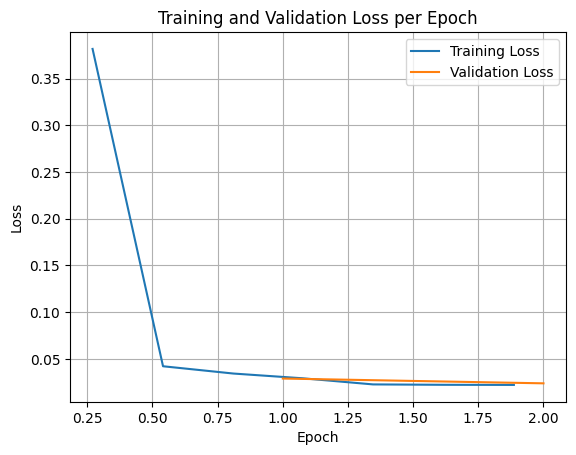

In [28]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
trainer.save_model()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

## Test the trained model

In [30]:
del model
del trainer
torch.cuda.empty_cache()

In [32]:
CHECKPOINT_DIR_NAME = training_args.output_dir #'berkeruveyik/smolvlm2-256m-FoodExtract-Vision-v2-without-peft'
CHECKPOINT_DIR_NAME

'smolvlm2-500m-FoodExtract-Vision-v3'

In [33]:
# upload original model
from transformers import pipeline

pt_pipe = pipeline(
    'image-text-to-text',
    model=MODEL_ID,
    device='cuda',
    dtype=torch.bfloat16
)

# do_sample = False for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

In [34]:
# upload fine-tuned model
ft_pipe = pipeline(
    'image-text-to-text',
    model=CHECKPOINT_DIR_NAME,
    device='cuda',
    dtype=torch.bfloat16
)

# do_sample = False for deterministic responses
ft_pipe.model.generation_config.do_sample = True
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

In [35]:
pt_pipe.device, ft_pipe.device

(device(type='cuda'), device(type='cuda'))

[INFO] Random sample model input:
{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x320 at 0x7D0E24267F20>}, {'type': 'text', 'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

[INFO] Random sample model output:
{'role': 'assistant', 'content': [{'type': 'text', 'text': {'is_food': 1, 'image_title': 'brownie

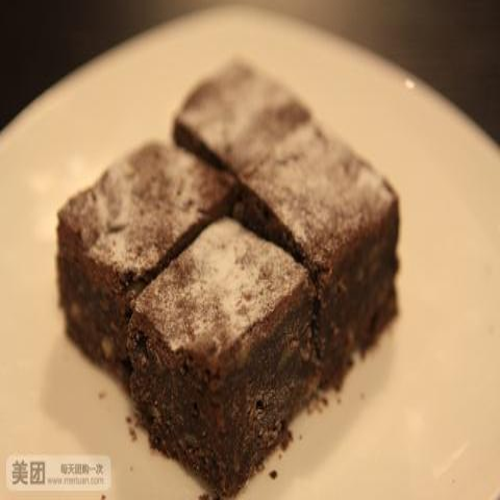

In [50]:
random_val_sample = random.choice(val_dataset)
random_val_sample_model_input = random_val_sample['messages'][1]
random_val_sample_model_output = random_val_sample['messages'][-1]
random_val_sample_image = random_val_sample_model_input['content'][0]['image']

print(f'[INFO] Random sample model input:\n{random_val_sample_model_input}')
print()
print(f'[INFO] Random sample model output:\n{random_val_sample_model_output}')

random_val_sample_image.resize((500,500))


In [51]:
pt_pipe_output = pt_pipe(text=[random_val_sample_model_input],
                        max_new_tokens=256)
pt_pipe_output_text = pt_pipe_output[0]["generated_text"][-1]["content"]
print (f" [INFO] Generated output text from pre-trained model: \n{pt_pipe_output_text}")
print()
ft_pipe_output = ft_pipe(text=[random_val_sample_model_input], max_new_tokens=256)
ft_pipe_output_text = ft_pipe_output[0]["generated_text"][-1]["content"]
print(f"[INFO] Generated output text from fine-tuned model: \n{ft_pipe_output_text}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 [INFO] Generated output text from pre-trained model: 
 [['chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake', 'chocolate cake',



Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Generated output text from fine-tuned model: 
 {'is_food': 1, 'image_title': 'brownie', 'food_items': ['chocolate chips', 'cocoa powder', 'butter', 'sugar', 'eggs', 'vanilla extract', 'lemon juice', 'cocoa powder'], 'drink_items': []}


## Training Stage 2: Unfreezing the vision encoder

In [52]:
model_Stage_1 = ft_pipe.model

total_params, trainable_params, frozen_params = count_parameters(model_Stage_1)
print(f'[INFO] Params Total: {total_params:,} | Trainable: {trainable_params:,} | Frozen: {frozen_params:,}')

for param in model_Stage_1.model.vision_model.parameters():
    param.requires_grad = True

total_params, trainable_params, frozen_params = count_parameters(model_Stage_1)
print(f'[INFO] Params Total: {total_params:,} | Trainable: {trainable_params:,} | Frozen: {frozen_params:,}')

[INFO] Params Total: 507,482,304 | Trainable: 507,482,304 | Frozen: 0
[INFO] Params Total: 507,482,304 | Trainable: 507,482,304 | Frozen: 0


In [53]:
from trl import SFTConfig

training_args_stage_2 = SFTConfig(
    output_dir="smolvlm2-500m-FoodExtract-Vision-v3-stage-2",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=1,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-6,
    bf16=True,
    save_total_limit=1,
    max_grad_norm=1.0,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to="none",
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    load_best_model_at_end=True,
)

training_args_stage_2.remove_unused_columns = False  # important for collator


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [54]:
from trl import SFTTrainer

trainer_stage_2 = SFTTrainer(
    model=model_Stage_1,
    args=training_args_stage_2,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=processor,
    data_collator=collate_fn
)

trainer_stage_2.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.017670,0.023476
2,0.022447,0.023339


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=186, training_loss=0.015501142199081119, metrics={'train_runtime': 4360.3805, 'train_samples_per_second': 1.357, 'train_steps_per_second': 0.043, 'total_flos': 2.353281940703232e+16, 'train_loss': 0.015501142199081119})

In [55]:
trainer_stage_2.save_model()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...stage-2/training_args.bin: 100%|##########| 5.71kB / 5.71kB            

  ...stage-2/model.safetensors:   4%|4         | 41.9MB / 1.02GB            

No files have been modified since last commit. Skipping to prevent empty commit.


In [56]:
CHECKPOINT_DIR_NAME_STAGE_2 = training_args_stage_2.output_dir #'/content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v2-smolVLM_Without_Peft/checkpoint-185'
print(f"[INFO] Checkpoint path: {CHECKPOINT_DIR_NAME_STAGE_2}")

[INFO] Checkpoint path: smolvlm2-500m-FoodExtract-Vision-v3-stage-2


In [57]:
ft_pipe_stage_2 = pipeline(
    'image-text-to-text',
    model=CHECKPOINT_DIR_NAME_STAGE_2,
    device='cuda',
    dtype=torch.bfloat16
)

ft_pipe_stage_2.model.generation_config.do_sample = True
ft_pipe_stage_2.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

[INFO] Random sample model input:
{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7D0DE61E03E0>}, {'type': 'text', 'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

[INFO] Random sample model output:
{'role': 'assistant', 'content': [{'type': 'text', 'text': {'is_food': 1, 'image_title': 'potato_

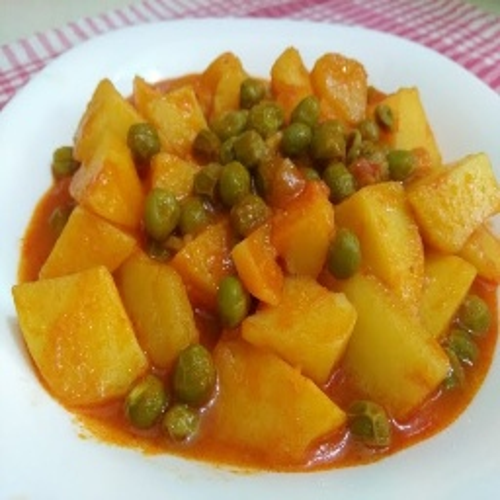

In [74]:
random_val_sample = random.choice(val_dataset)
random_val_sample_model_input = random_val_sample['messages'][1]
random_val_sample_model_output = random_val_sample['messages'][-1]
random_val_sample_image = random_val_sample_model_input['content'][0]['image']

print(f'[INFO] Random sample model input:\n{random_val_sample_model_input}')
print()
print(f'[INFO] Random sample model output:\n{random_val_sample_model_output}')

random_val_sample_image.resize((500,500))


In [75]:
pt_pipe_output = pt_pipe(text=[random_val_sample_model_input],
                        max_new_tokens=256)
pt_pipe_output_text = pt_pipe_output [0] ["generated_text"][-1] ["content"]
print (f" [INFO] Generated output text from pre-trained model: \n{pt_pipe_output_text}")


print()

ft_pipe_output = ft_pipe(text=[random_val_sample_model_input],
                         max_new_tokens=256)
ft_pipe_output_text = ft_pipe_output [0] ["generated_text"][-1] ["content"]
print(f"[INFO] Generated output text from fine-tuned_Stage_1 model: \n{ft_pipe_output_text}")


print()

ft_pipe_stage_2_output = ft_pipe_stage_2(text=[random_val_sample_model_input],
                                         max_new_tokens=256)
ft_pipe_stage_2_output_text = ft_pipe_stage_2_output [0] ["generated_text"][-1] ["content"]
print(f"[INFO] Generated output text from fine-tuned_2 model: \n{ft_pipe_stage_2_output_text}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 [INFO] Generated output text from pre-trained model: 
 [
]



Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Generated output text from fine-tuned_Stage_1 model: 
 {'is_food': 1, 'image_title': 'pot_kebab', 'food_items': ['kebab meat', 'rice', 'vegetables', 'sauce'], 'drink_items': []}



Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Generated output text from fine-tuned_2 model: 
 {'is_food': 1, 'image_title': 'pot_kebab', 'food_items': ['meat', 'rice', 'vegetables', 'sauce'], 'drink_items': []}


### Test the custom image

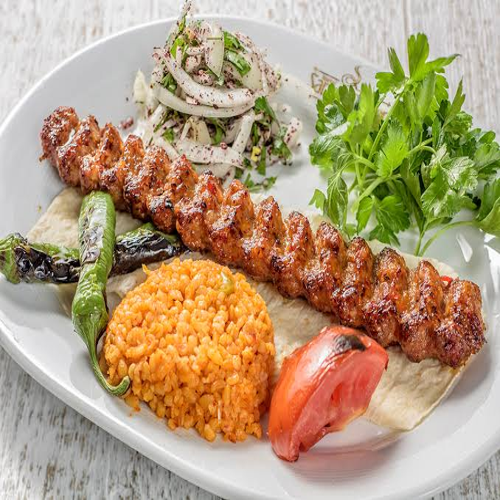

In [77]:
image_path ='/content/IMG_3808.JPG'
image = Image.open(image_path)
image =image.resize((500,500))
image

In [78]:
random_val_sample_model_input

{'role': 'user',
 'content': [{'type': 'image',
   'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>},
  {'type': 'text',
   'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

In [79]:
def format_sample_to_message(input_image):
  return{'role': 'user',
 'content': [{'type': 'image',
   'image': input_image},
  {'type': 'text',
   'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

In [80]:
test_input_sample = format_sample_to_message(image)
test_input_sample

{'role': 'user',
 'content': [{'type': 'image',
   'image': <PIL.Image.Image image mode=RGB size=500x500>},
  {'type': 'text',
   'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

In [81]:
# Run the model on our example sample
val_chat_template_input = processor.apply_chat_template(
    [test_input_sample],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors='pt'
).to(device)#DEVICE # Move input to model's device and dtype, ensuring type consistency

# example_chat_template_input

input_len = val_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

with torch.inference_mode():
  val_generation_output_full = ft_pipe_stage_2.model.generate(**val_chat_template_input,
                                    max_new_tokens=256,
                                    do_sample=False)
  val_generation_output_short = val_generation_output_full[0][input_len:]

val_decoded_outputs = processor.decode(val_generation_output_short,
                                   skip_special_tokens=True)

print(val_decoded_outputs)

[INFO] Input length: 1315
 {'is_food': 1, 'image_title': 'lahmacun', 'food_items': ['meat', 'onion', 'herbs', 'spices', 'pita bread'], 'drink_items': []}


[INFO] Model outputs:  {'is_food': 1, 'image_title': 'lahmacun', 'food_items': ['meat', 'onion', 'herbs', 'spices', 'pita bread'], 'drink_items': []}


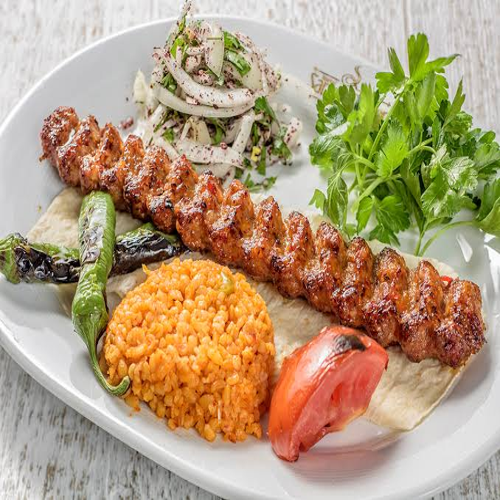

In [82]:
print(f"[INFO] Model outputs: {val_decoded_outputs}")
image.resize(size=(500, 500))

## Upload to Hugging Face

In [ ]:
from huggingface_hub import HfApi, create_repo

api = HfApi()

repo_id = "berkeruveyik/FoodExtraqt-Vision-SmoLVLM2-500M-fine-tune-v3"

create_repo(repo_id,
            repo_type='model',
            exist_ok=True)

api.upload_folder(
    folder_path='',
    repo_id=repo_id,
    repo_type="model",
)

### Create a demo with gradio

In [83]:
import gradio as gr
import json
import torch

def predict(image):
    if image is None:
        return None

    # Prepare the message structure
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": USER_PROMPT}
            ]
        }
    ]

    # Prepare inputs using the processor
    # We use the device from the pipeline model
    device = ft_pipe_stage_2.model.device

    model_inputs = processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to(device)

    # Generate response
    with torch.inference_mode():
        generated_ids = ft_pipe_stage_2.model.generate(
            **model_inputs,
            max_new_tokens=256,
            do_sample=False # Deterministic for the demo
        )

    # Decode output
    input_len = model_inputs["input_ids"].shape[-1]
    decoded_text = processor.decode(generated_ids[0][input_len:], skip_special_tokens=True)

    # Try to parse JSON
    try:
        # Simple cleanup to remove markdown code blocks if the model generates them
        clean_text = decoded_text.replace("```json", "").replace("```", "").strip()
        return json.loads(clean_text)
    except json.JSONDecodeError:
        # Fallback if not valid JSON
        return {"raw_output": decoded_text, "error": "Could not parse JSON"}

# Create Gradio Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Food Image"),
    outputs=gr.JSON(label="Extracted Tags"),
    title="Food Tag Extraction (Stage 2 Model)",
    description="Upload an image to classify it as food/not-food and extract tags using the fine-tuned SmolVLM model."
)

# Launch
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bf8e80a8d8066d3da7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bf8e80a8d8066d3da7.gradio.live


In [9]:
%%writefile demos/FoodExtract-Vision/app.py
import torch
import gradio as gr
import spaces
from transformers import pipeline

BASE_MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"
FINE_TUNED_MODEL_ID = 'berkeruveyik/FoodExtraqt-Vision-SmoLVLM2-500M-fine-tune-v3'
OUTPUT_TOKENS = 256

print(f"[INFO] Loading Original Model")
original_pipeline = pipeline("image-text-to-text", model=BASE_MODEL_ID, dtype=torch.bfloat16, device_map="auto")

print(f"[INFO] Loading Fine-tuned Model")
ft_pipe = pipeline("image-text-to-text", model=FINE_TUNED_MODEL_ID, dtype=torch.bfloat16, device_map="auto")

def create_message(input_image):
    return [{'role': 'user', 'content': [{'type': 'image', 'image': input_image}, {'type': 'text', 'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items': [], # list[str] - list of visible edible food item nouns\n  'drink_items': [] # list[str] - list of visible edible drink item nouns\n}\n```\n"}]}]

@spaces.GPU
def extract_foods_from_image(input_image):
    input_image = input_image.resize(size=(512, 512))
    input_message = create_message(input_image=input_image)
    original_pipeline_output = original_pipeline(text=[input_message], max_new_tokens=OUTPUT_TOKENS)
    outputs_pretrained = original_pipeline_output[0][0]["generated_text"][-1]["content"]
    ft_pipe_output = ft_pipe(text=[input_message], max_new_tokens=OUTPUT_TOKENS)
    outputs_fine_tuned = ft_pipe_output[0][0]["generated_text"][-1]["content"]
    return outputs_pretrained, outputs_fine_tuned

demo_title = "🍕🔍 FoodExtract-Vision: Fine-tuned SmolVLM2-500M"
demo_description = """* **Base model:** https://huggingface.co/HuggingFaceTB/SmolVLM2-500M-Video-Instruct\n* **Fine-tuning dataset:** https://huggingface.co/datasets/berkeruveyik/vlm-food-4k-not-food-dataset\n* **Fine-tuned model:** https://huggingface.co/berkeruveyik/FoodExtract-Vision-SmolVLM2-500M-fine-tune-v3\n\n## 📋 Overview\n\nThis demo showcases the power of fine-tuning for structured output generation. Compare a base vision-language model against its fine-tuned version specialized in extracting food and drink items from images in JSON format.\n\nThe **base model** often fails to follow the required output structure, producing inconsistent or unstructured responses. The **fine-tuned model** reliably generates valid JSON outputs matching the specified schema.\n\n## 🎯 Task Description\n\nBoth models receive identical input prompts requesting food/drink classification and extraction:\n\n````\nClassify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items': [], # list[str] - list of visible edible food item nouns\n  'drink_items': [] # list[str] - list of visible edible drink item nouns\n}\n```\n````\n\n## 🔧 Training Details\n\nThe fine-tuned model was trained on **3,698 images** from the vlm-food-4k-not-food-dataset:\n- **Food images:** Multiple categories from the Food270 dataset including various cuisines, ingredients, and prepared dishes\n- **Non-food images:** Random internet images to teach the model to correctly identify non-food content\n- Each image is labeled with structured JSON outputs including classification, titles, and extracted food/drink items"""

demo = gr.Interface(fn=extract_foods_from_image, inputs=gr.Image(type="pil"), title=demo_title, description=demo_description, outputs=[gr.Textbox(lines=4, label="Original Model (not fine-tuned)"), gr.Textbox(lines=4, label="Fine-tuned Model")], examples=[["./examples/36741.jpg"], ["./examples/IMG_3808.JPG"], ["./examples/istockphoto-175500494-612x612.jpg"]])

if __name__ == "__main__":
    demo.launch(share=True)

Overwriting demos/FoodExtract-Vision/app.py


In [13]:
%%writefile demos/FoodExtract-Vision/README.md
---
title: FoodExtract-Vision
emoji: 🍕
colorFrom: red
colorTo: yellow
sdk: gradio
sdk_version: "5.50.0"
python_version: "3.12"
app_file: app.py
pinned: false
---

# 🍕🔍 FoodExtract-Vision v1: Fine-tuned SmolVLM2-500M for Structured Food Tag Extraction

[![Model on HuggingFace](https://img.shields.io/badge/🤗%20Model-FoodExtract--Vision--SmolVLM2--500M-blue)](https://huggingface.co/berkeruveyik/FoodExtract-Vision-SmolVLM2-500M-fine-tune-v3)
[![Dataset on HuggingFace](https://img.shields.io/badge/🤗%20Dataset-vlm--food--4k--not--food-green)](https://huggingface.co/datasets/berkeruveyik/vlm-food-4k-not-food-dataset)
[![Base Model](https://img.shields.io/badge/🧠%20Base-SmolVLM2--500M--Video--Instruct-orange)](https://huggingface.co/HuggingFaceTB/SmolVLM2-500M-Video-Instruct)
[![License](https://img.shields.io/badge/📄%20License-Apache%202.0-lightgrey)](https://www.apache.org/licenses/LICENSE-2.0)

---

## 📋 Overview

**FoodExtract-Vision** is a fine-tuned Vision-Language Model (VLM) that takes any image as input and produces **structured JSON output** classifying whether food/drink items are visible and extracting them into organized lists.

Built on top of [SmolVLM2-500M-Video-Instruct](https://huggingface.co/HuggingFaceTB/SmolVLM2-500M-Video-Instruct), this project demonstrates that even **small (~500M parameter) VLMs** can be fine-tuned to reliably produce structured outputs for domain-specific tasks — without needing PEFT/LoRA adapters.

> 💡 **Key Insight:** The base model often fails to follow the required JSON output structure, producing inconsistent or unstructured responses. After two-stage fine-tuning, the model **reliably generates valid JSON** matching the specified schema.

---

## 🎯 What Does It Do?

| | Input | Output |
|---|---|---|
| 📸 | Any image (food or non-food) | Structured JSON |

### Output Schema

```json
{
  "is_food": 1,
  "image_title": "Tandoori chicken with naan bread",
  "food_items": ["tandoori chicken", "naan bread", "rice", "salad"],
  "drink_items": ["lassi"]
}
```

| Field | Type | Description |
|---|---|---|
| `is_food` | `int` | `0` = no food/drink visible, `1` = food/drink visible |
| `image_title` | `str` | Short food-related caption (blank if no food) |
| `food_items` | `list[str]` | List of visible edible food item nouns |
| `drink_items` | `list[str]` | List of visible edible drink item nouns |

---

## 🛠️ What Was Done — End-to-End Pipeline

This project covers the **full ML lifecycle** from dataset creation to deployment:

### Step 1: 📊 Dataset Creation (`00_create_vlm_dataset.ipynb`)

1. 🏷️ Loaded food labels from `data/food_dataset-2.jsonl` (generated via Qwen3-VL-8B inference on Food270 images)
2. 📝 Added metadata fields (`image_id`, `image_name`, `food270_class_name`, `image_source`)
3. 🖼️ Sampled **not-food images** from `data/not_food/` and created empty labels with `is_food = 0`
4. 🔀 Merged food + not-food labels into a unified dataset
5. 📁 Copied all images into `data/food_all/` and wrote `metadata.jsonl` for HuggingFace `imagefolder` format
6. 🚀 Pushed to HuggingFace Hub as [`berkeruveyik/vlm-food-4k-not-food-dataset`](https://huggingface.co/datasets/berkeruveyik/vlm-food-4k-not-food-dataset)

**Final dataset:** ~3,698 image-JSON pairs across **270 food categories** + not-food images

### Step 2: 🧪 Base Model Evaluation (`01_fine_tune_vlm_v3_smolVLM_500m.ipynb`)

- Tested `SmolVLM2-500M-Video-Instruct` on the food extraction task
- **Result:** The base model produced unstructured text like *"The given image is a food or drink item."* instead of valid JSON
- ❌ Base model **cannot** follow the structured output format

### Step 3: 📐 Data Formatting for SFT

Converted each sample to a **conversational message format** with three roles:

```
[SYSTEM] → Expert food extractor persona
[USER]   → Image + JSON extraction prompt
[ASSISTANT] → Ground truth JSON output
```

- Used `PIL.Image` objects directly (not bytes) to preserve image quality
- 80/20 train/validation split with `random.seed(42)` for reproducibility

### Step 4: 🧊 Stage 1 Training — Frozen Vision Encoder

- **Froze** the vision encoder (`model.model.vision_model`)
- **Trained** only the LLM + connector layers
- **Goal:** Teach the language model to output valid JSON structure
- Used `SFTTrainer` from TRL with custom `collate_fn` for image-text batching

### Step 5: 🔥 Stage 2 Training — Full Model Fine-tuning

- **Unfroze** the vision encoder
- **Trained** all parameters with a **100x lower learning rate** (`2e-6` vs `2e-4`)
- **Goal:** Allow the vision encoder to adapt for better food recognition without catastrophic forgetting

### Step 6: 📈 Evaluation & Comparison

- Compared outputs from 3 models side-by-side:
  - 🔴 **Pre-trained** (base model) — fails at structured output
  - 🟡 **Stage 1** (frozen vision) — learns JSON format
  - 🟢 **Stage 2** (full fine-tune) — best food recognition + JSON format

### Step 7: 🚀 Deployment

- Uploaded fine-tuned model to HuggingFace Hub
- Built Gradio demo with side-by-side comparison
- Deployed as a HuggingFace Space

---

## 🏗️ Architecture & Training Details

### 🧠 Base Model

| Property | Value |
|---|---|
| Model | `HuggingFaceTB/SmolVLM2-500M-Video-Instruct` |
| Parameters | ~500M |
| Precision | `bfloat16` |
| Attention | `eager` |

### 📊 Dataset

| Property | Value |
|---|---|
| Source | [`berkeruveyik/vlm-food-4k-not-food-dataset`](https://huggingface.co/datasets/berkeruveyik/vlm-food-4k-not-food-dataset) |
| Total Samples | ~3,698 image-JSON pairs |
| Train / Val Split | 80% / 20% |
| Food Categories | 270 (from Food270 dataset) |
| Non-food Images | Random internet images |
| Label Source | Qwen3-VL-8B inference outputs |

### 🔧 Two-Stage Training Strategy

Inspired by the [SmolVLM Docling paper](https://arxiv.org/pdf/2503.11576):

#### 🧊 Stage 1: LLM Alignment (Frozen Vision Encoder)

| Parameter | Value |
|---|---|
| Vision Encoder | ❄️ Frozen |
| Trainable | LLM + connector layers |
| Learning Rate | `2e-4` |
| Epochs | 2 |
| Batch Size | 8 × 4 gradient accumulation = effective 32 |
| Optimizer | `adamw_torch_fused` |
| LR Scheduler | `constant` |
| Warmup Ratio | `0.03` |
| Precision | `bf16` |

#### 🔥 Stage 2: Full Model Fine-tuning (Unfrozen Vision Encoder)

| Parameter | Value |
|---|---|
| Vision Encoder | 🔥 Unfrozen |
| Trainable | All parameters |
| Learning Rate | `2e-6` (100x lower than Stage 1) |
| Epochs | 2 |
| Batch Size | 8 × 4 gradient accumulation = effective 32 |
| Optimizer | `adamw_torch_fused` |
| LR Scheduler | `constant` |
| Warmup Ratio | `0.03` |
| Precision | `bf16` |

---

## 🚀 Quick Start

### 📦 Installation

```bash
pip install transformers torch gradio spaces accelerate
```

### 🔮 Inference with Pipeline

```python
import torch
from transformers import pipeline
from PIL import Image

FINE_TUNED_MODEL_ID = "berkeruveyik/FoodExtraqt-Vision-SmoLVLM2-500M-fine-tune-v3"

pipe = pipeline(
    "image-text-to-text",
    model=FINE_TUNED_MODEL_ID,
    dtype=torch.bfloat16,
    device_map="auto",
)

prompt = """Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.

Only return valid JSON in the following form:

```json
{
  "is_food": 0,
  "image_title": "",
  "food_items": [],
  "drink_items": []
}
```
"""

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "path/to/your/image.jpg"},
            {"type": "text", "text": prompt},
        ],
    }
]

output = pipe(text=messages, max_new_tokens=256)
print(output[0][0]["generated_text"][-1]["content"])
```

### 🧪 Inference without Pipeline

```python
import torch
from transformers import AutoModelForImageTextToText, AutoProcessor
from PIL import Image

FINE_TUNED_MODEL_ID = "berkeruveyik/FoodExtraqt-Vision-SmoLVLM2-500M-fine-tune-v3"

model = AutoModelForImageTextToText.from_pretrained(
    FINE_TUNED_MODEL_ID,
    attn_implementation="eager",
    dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained(FINE_TUNED_MODEL_ID)

image = Image.open("path/to/your/image.jpg")

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "YOUR_PROMPT_HERE"},
        ],
    }
]

inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    output = model.generate(**inputs, max_new_tokens=256, do_sample=False)

decoded = processor.decode(output[0][input_len:], skip_special_tokens=True)
print(decoded)
```

---

## 🎮 Gradio Demo

This Space runs a **side-by-side comparison** between the base model and the fine-tuned model.

### ▶️ Running Locally

```bash
cd demos/FoodExtract-Vision
pip install -r requirements.txt
python app.py
```

### 🖥️ What the Demo Shows

1. 📤 **Upload** any image
2. 🔄 **Compare** outputs from the base model vs. the fine-tuned model side-by-side
3. 📊 See how fine-tuning enables **reliable structured JSON extraction**

### 📸 Example Images Included

The demo comes with pre-loaded examples to try instantly.

---

## 📁 Project Structure

```
vlm_finetune/
├── 📓 00_create_vlm_dataset.ipynb          # Dataset creation pipeline
├── 📓 01-fine_tune_vlm.ipynb               # First fine-tuning experiment (Gemma-3n)
├── 📓 01-fine_tune_vlm-v2-smolVLM.ipynb    # SmolVLM 256M experiment
├── 📓 01_fine_tune_vlm_v3_smolVLM_500m.ipynb # ✅ Final: SmolVLM 500M two-stage training
├── 📓 qwen3-food270-inference-viewer.ipynb  # Dataset visualization tool
├── 📄 README.md                            # Root project README
├── 📁 data/
│   ├── food_dataset-2.jsonl                # Qwen3-VL-8B inference outputs
│   ├── food_labels_updated.json            # Processed food labels
│   ├── 📁 10_images_270_class/             # 10 sample images per category
│   ├── 📁 food_all/                        # Merged dataset (food + not-food)
│   │   └── metadata.jsonl                  # HuggingFace imagefolder metadata
│   └── 📁 not_food/                        # Non-food images
└── 📁 demos/
    └── 📁 FoodExtract-Vision/
        ├── app.py                          # 🚀 Gradio demo application
        ├── README.md                       # 📖 This file
        ├── requirements.txt                # 📦 Python dependencies
        └── 📁 examples/                    # 🖼️ Example images
            ├── 36741.jpg
            ├── IMG_3808.JPG
            └── istockphoto-175500494-612x612.jpg
```

---

## 📝 Key Learnings & Notes

### ✅ What Worked

- 🏗️ **Two-stage training** significantly improved output quality compared to single-stage
- 🧊 **Freezing the vision encoder first** let the LLM learn JSON format without vision interference
- 🐢 **100x lower learning rate in Stage 2** (`2e-6` vs `2e-4`) prevented catastrophic forgetting
- 🤏 Even a **500M parameter model** can learn reliable structured output generation
- 📝 **Custom `collate_fn`** with proper label masking (pad tokens + image tokens → `-100`) was essential
- 🔀 **`remove_unused_columns = False`** is critical when using a custom data collator with `SFTTrainer`

### ⚠️ Important Notes

- **Dtype consistency:** Model inputs must match the model's dtype (e.g., `bfloat16` inputs for a `bfloat16` model)
- **System prompt handling:** When not using `transformers.pipeline`, the system prompt may need to be folded into the user prompt
- **PIL images over bytes:** Using `format_data()` as a list comprehension instead of `dataset.map()` preserves PIL image types
- **Gradient checkpointing:** Set `use_reentrant=False` to avoid warnings and ensure compatibility

### 🧪 Experiments Tried

| Notebook | Model | Approach | Result |
|---|---|---|---|
| `01-fine_tune_vlm.ipynb` | Gemma-3n-E2B | QLoRA + PEFT | ✅ Works but larger model |
| `01-fine_tune_vlm-v2-smolVLM.ipynb` | SmolVLM2-256M | Full fine-tune | 🟡 Limited capacity |
| `01_fine_tune_vlm_v3_smolVLM_500m.ipynb` | SmolVLM2-500M | **Two-stage full fine-tune** | ✅ **Best results** |

---

## 🔗 Links

| Resource | URL |
|---|---|
| 🤗 Fine-tuned Model | [berkeruveyik/FoodExtraqt-Vision-SmoLVLM2-500M-fine-tune-v3](https://huggingface.co/berkeruveyik/FoodExtraqt-Vision-SmoLVLM2-500M-fine-tune-v3) |
| 🤗 Dataset | [berkeruveyik/vlm-food-4k-not-food-dataset](https://huggingface.co/datasets/berkeruveyik/vlm-food-4k-not-food-dataset) |
| 🤗 Base Model | [HuggingFaceTB/SmolVLM2-500M-Video-Instruct](https://huggingface.co/HuggingFaceTB/SmolVLM2-500M-Video-Instruct) |
| 📄 SmolVLM Docling Paper | [arxiv.org/pdf/2503.11576](https://arxiv.org/pdf/2503.11576) |
| 📚 TRL Documentation | [huggingface.co/docs/trl](https://huggingface.co/docs/trl/main/en/index) |
| 📚 PEFT GitHub | [github.com/huggingface/peft](https://github.com/huggingface/peft) |
| 📚 HF Vision Fine-tune Guide | [ai.google.dev/gemma/docs](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora?hl=tr) |

---

## 📄 License

This project uses Apache 2.0 license. Please refer to the respective model and dataset cards for additional licensing information.

---

*Built with ❤️ using 🤗 Transformers, TRL, and Gradio — by [Berker Üveyik](https://huggingface.co/berkeruveyik)*

Overwriting demos/FoodExtract-Vision/README.md


In [17]:
%%writefile demos/FoodExtract-Vision/requirements.txt
transformers
torch
torchvision
gradio
spaces
accelerate
num2words

Overwriting demos/FoodExtract-Vision/requirements.txt


In [18]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/FoodExtract-Vision/"
HF_TARGET_SPACE_NAME = "FoodExtract-Vision"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub 
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists 
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading FoodExtract-Vision demo folder",
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face Hub with name: FoodExtract-Vision
[INFO] Full Hugging Face Hub repo name: berkeruveyik/FoodExtract-Vision
[INFO] Uploading demos/FoodExtract-Vision/ to repo: berkeruveyik/FoodExtract-Vision
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/berkeruveyik/FoodExtract-Vision/tree/main/.


## Uploading the model to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os
from google.colab import drive


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


source_dir = '/content/smolvlm2-256m-FoodExtract-Vision-v2-without-peft-stage-2'
destination_dir = "/content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v2-smolVLM_Without_Peft"

print(f"[INFO] Model kopyalanıyor...\nKaynak: {source_dir}\nHedef:  {destination_dir}")


try:

    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"\n[BAŞARILI] Model Google Drive'a başarıyla kaydedildi! ✅")
    print(f"Konum: {destination_dir}")
except Exception as e:
    print(f"\n[HATA] Kayıt sırasında bir sorun oluştu: {e} ❌")

Mounted at /content/drive
[INFO] Model kopyalanıyor...
Kaynak: /content/smolvlm2-256m-FoodExtract-Vision-v2-without-peft-stage-2
Hedef:  /content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v2-smolVLM_Without_Peft

[BAŞARILI] Model Google Drive'a başarıyla kaydedildi! ✅
Konum: /content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v2-smolVLM_Without_Peft


### Notes

* **Datatypes:** Make sure model inputs are the same dtype as the model loaded (e.g. if model is quantized, inputs should be quanized too or if model is bfloat16, inputs should be bfloat16 as well)

* **Prompt inputs:** If not using `transformers.pipeline` beware that the system_prompt may have to be folded into the user_prompt, otherwise there will be errors.